In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import gensim#For word2vec, etc

import requests #for http requests
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls
import seaborn as sns#Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('merged.csv')#['tokenized_text'][:30]

In [4]:
def na_value(x):
    if type(x) == float:
        return ''
    else:
        return x

df['title'] = df['title'].apply(na_value)

np.sum(df['title'].apply(lambda x: type(x) == float))

0

In [5]:
%%time
df['tokenized_text'] = df['title'].apply(lambda x: lucem_illud.word_tokenize(x))
df['normalized_tokens'] = df['title'].apply(lambda x: lucem_illud.normalizeTokens(x))

CPU times: user 5min 41s, sys: 15.6 s, total: 5min 56s
Wall time: 6min 38s


In [6]:
df['gme'] = df['normalized_tokens'].apply(lambda x: 1 if 'gme' in x or 'gamestop' in x or '$gme' in x else 0)

In [77]:
np.sum(df['normalized_tokens'].apply(lambda x: 1 if 'gme' in x or 'gamestop' in x or '$gme' in x or 'gamestonk' in x else 0))

168030

In [7]:
gme = df[df['gme'] == 1]

In [23]:
df_agg = df.groupby('time').sum()[['score', 'num_comments']]
df_agg

,score,num_comments
time,,
2020-12-20,92583,33758
2020-12-21,130063,62195
2020-12-22,225018,68228
2020-12-23,125710,58231
2020-12-24,86317,37532
...,...,...
2021-06-16,122479,73131
2021-06-17,118174,62131
2021-06-18,122215,72881


In [24]:
gme_agg = df[df['gme'] == 1].groupby('time').sum('gme')[['gme', 'score', 'num_comments']]
gme_agg

,gme,score,num_comments
time,,,
2020-12-20,17,3337,474
2020-12-21,36,7203,1602
2020-12-22,111,41700,4343
2020-12-23,132,22754,3318
2020-12-24,74,16714,2250
...,...,...,...
2021-06-16,73,3445,1084
2021-06-17,79,1704,386
2021-06-18,56,1507,399


In [25]:
df_count = df.groupby('time').count()

In [26]:
gme_agg['score_tt'] = df_agg['score']
gme_agg['tt'] = df_count['score']
gme_agg['num_comments_tt'] = df_agg['num_comments']
gme_agg['num_p'] = gme_agg['gme']/gme_agg['tt']
gme_agg['score_p'] = gme_agg['score']/gme_agg['score_tt']
gme_agg['comment_p'] = gme_agg['num_comments']/gme_agg['num_comments_tt']

In [27]:
gme_agg

,gme,score,num_comments,score_tt,tt,num_comments_tt,num_p,score_p,comment_p
time,,,,,,,,,
2020-12-20,17,3337,474,92583,616,33758,0.027597,0.036043,0.014041
2020-12-21,36,7203,1602,130063,1312,62195,0.027439,0.055381,0.025758
2020-12-22,111,41700,4343,225018,1441,68228,0.077030,0.185319,0.063654
2020-12-23,132,22754,3318,125710,1289,58231,0.102405,0.181004,0.056980
2020-12-24,74,16714,2250,86317,889,37532,0.083240,0.193635,0.059949
...,...,...,...,...,...,...,...,...,...
2021-06-16,73,3445,1084,122479,3275,73131,0.022290,0.028127,0.014823
2021-06-17,79,1704,386,118174,3161,62131,0.024992,0.014419,0.006213
2021-06-18,56,1507,399,122215,2651,72881,0.021124,0.012331,0.005475


<Figure size 432x288 with 0 Axes>

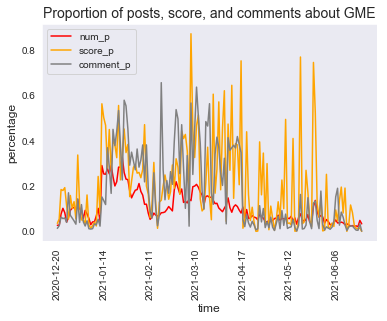

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

fig = plt.figure()
gme_agg[['num_p', 'score_p', 'comment_p']].plot(label = ['p_posts', 'p_score', 'p_comments'], color = ['red', 'orange', 'grey'])
plt.xticks(rotation = 90)
fig.autofmt_xdate()
plt.title('Proportion of posts, score, and comments about GME', fontsize = 14)
plt.ylabel('percentage', fontsize = 12)
plt.xlabel('time', fontsize = 12);

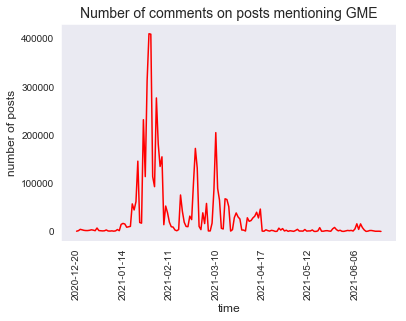

In [59]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

gme_agg['num_comments'].plot(color = 'red')
plt.xticks(rotation = 90)
plt.title('Number of comments on posts mentioning GME', fontsize = 14)
plt.ylabel('number of posts', fontsize = 12)
plt.xlabel('time', fontsize = 12);

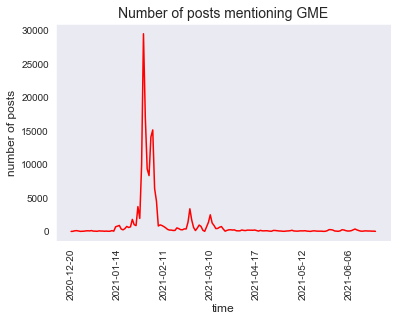

In [32]:
gme_agg['gme'].plot(color = 'red')
plt.xticks(rotation = 90)
plt.title('Number of posts mentioning GME', fontsize = 14)
plt.ylabel('number of posts', fontsize = 12)
plt.xlabel('time', fontsize = 12);

In [63]:
gme_agg.iloc[41]['tt']

55933.0

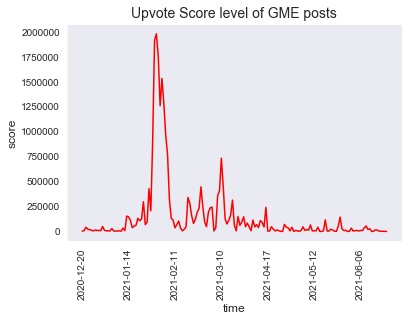

In [60]:
gme_agg['score'].plot(color = 'red')
plt.xticks(rotation = 90)
plt.title('Upvote Score level of GME posts', fontsize = 14)
plt.ylabel('score', fontsize = 12)
plt.xlabel('time', fontsize = 12);

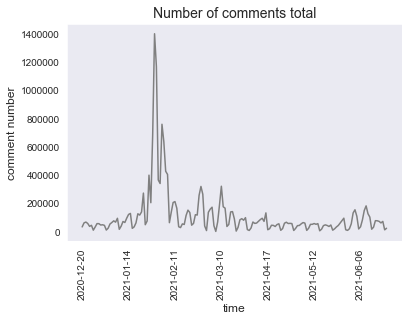

In [233]:
gme_agg['num_comments_tt'].plot(color = 'grey')
plt.xticks(rotation = 90)
plt.title('Number of comments total', fontsize = 14)
plt.ylabel('number of comments', fontsize = 12)
plt.xlabel('time', fontsize = 12);

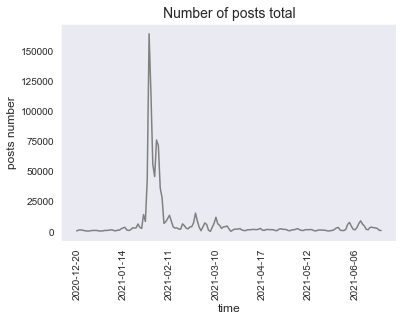

In [232]:
gme_agg['tt'].plot(color = 'grey')
plt.xticks(rotation = 90)
plt.title('Number of posts total', fontsize = 14)
plt.ylabel('number of posts', fontsize = 12)
plt.xlabel('time', fontsize = 12);

In [90]:
#gme_agg[:50]

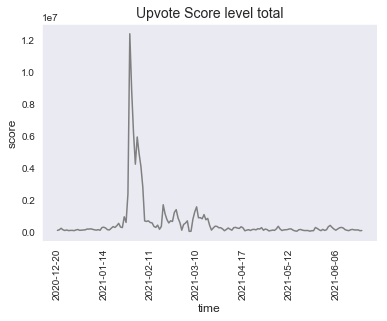

In [221]:
gme_agg['score_tt'].plot(color = 'grey')
plt.xticks(rotation = 90)
plt.title('Upvote Score level total', fontsize = 14)
plt.ylabel('score', fontsize = 12)
plt.xlabel('time', fontsize = 12);

In [61]:
df_mean = df.groupby('time').mean()[['num_comments', 'score']]

In [62]:
gme_mean = df[df['gme'] == 1].groupby('time').mean()[['num_comments', 'score']]

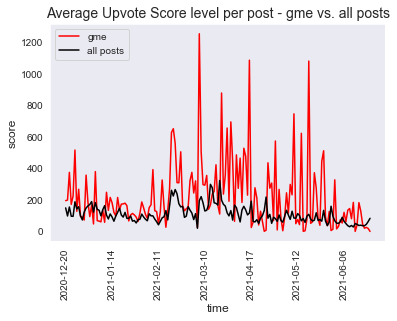

In [64]:
sns.set_style("dark")
gme_mean['score'].plot(label = 'gme', color = 'red')
df_mean['score'].plot(label = 'all posts', color = 'black')
plt.xticks(rotation = 90)
plt.title('Average Upvote Score level per post - gme vs. all posts', fontsize = 14)
plt.ylabel('score', fontsize = 12)
plt.xlabel('time', fontsize = 12)
plt.legend(loc="upper left");

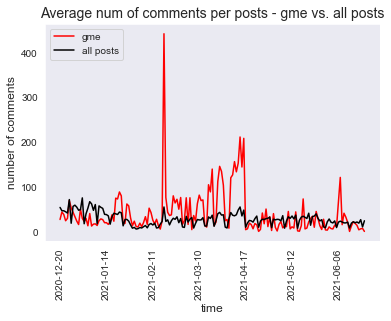

In [65]:
gme_mean['num_comments'].plot(label = 'gme', color = 'red')
df_mean['num_comments'].plot(label = 'all posts', color = 'black')
plt.xticks(rotation = 90)
plt.title('Average num of comments per posts - gme vs. all posts', fontsize = 14)
plt.ylabel('number of comments', fontsize = 12)
plt.xlabel('time', fontsize = 12)
plt.legend(loc="upper left");

In [8]:
df_before = df[df['time'] <= '2021-01-20']

In [9]:
#df_in = 
a = df[df['time'] > '2021-01-20'] #and 
df_in = a[a['time'] <= '2021-02-20']

In [10]:
df_after = df[df['time'] > '2021-05-20']

## 2020-12-20 - 2021-01-20

In [88]:
%%time
tokens_tt_bf = df_before['normalized_tokens'].sum()

CPU times: user 1min 24s, sys: 4.48 s, total: 1min 28s
Wall time: 1min 58s


In [264]:
text_tt_bf = ' '.join(tokens_tt_bf)

In [79]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [89]:
countedWords = wordCounter(tokens_tt_bf)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:20]

,word,count
124,🚀,27948
4,$,7521
106,gme,6455
176,buy,2881
11,stock,2261
143,moon,2213
734,bb,1750
89,go,1740
2,retard,1583
5,pltr,1582


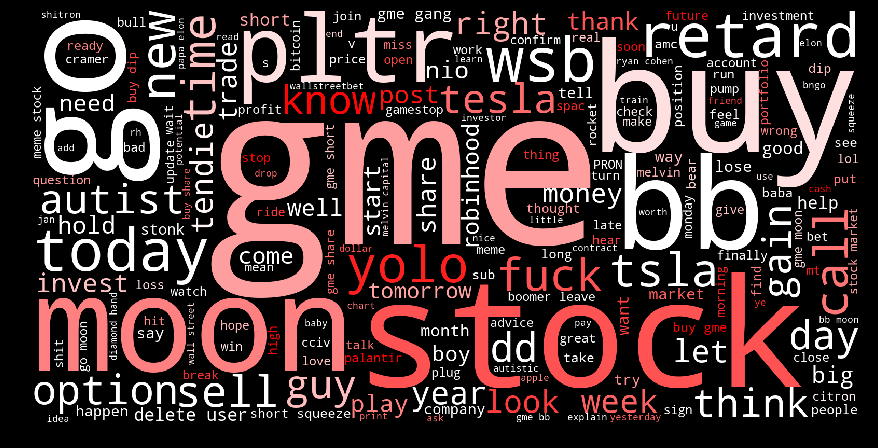

In [265]:
plot_word_cloud(text_tt_bf)

## 2021-01-20 - 2021-02-20

In [15]:
%%time
tokens_tt_in = df_in['normalized_tokens'].sum()

CPU times: user 6h 48min 53s, sys: 24min 27s, total: 7h 13min 21s
Wall time: 7h 16min 19s


In [16]:
text_tt_in = ' '.join(tokens_tt_in)

In [85]:
countedWords = wordCounter(tokens_tt_in)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:20]

,word,count
18,🚀,323359
31,gme,123357
78,buy,93617
46,$,91193
80,hold,74319
71,💎,64896
1203,amc,64618
96,stock,48088
1028,robinhood,41526
159,moon,34765


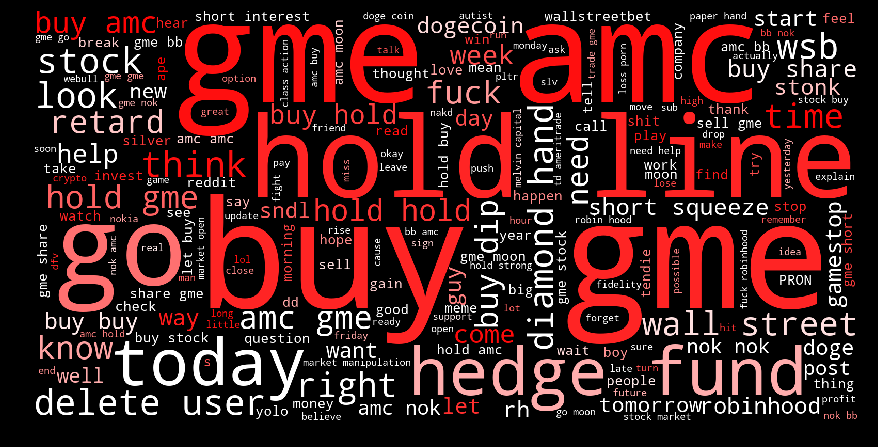

In [17]:
plot_word_cloud(text_tt_in)

## 2021-05-20 - 2021-06-20

In [12]:
%%time
tokens_tt_after = df_after['normalized_tokens'].sum()

CPU times: user 7min 4s, sys: 25 s, total: 7min 29s
Wall time: 8min 9s


In [13]:
text_tt_after = ' '.join(tokens_tt_after)

In [84]:
countedWords = wordCounter(tokens_tt_after)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:20]

,word,count
61,🚀,25629
7,$,22636
171,amc,11979
76,short,7692
55,moon,6659
172,stock,6467
34,buy,6340
66,ape,6277
1105,bb,5969
340,🦍,4576


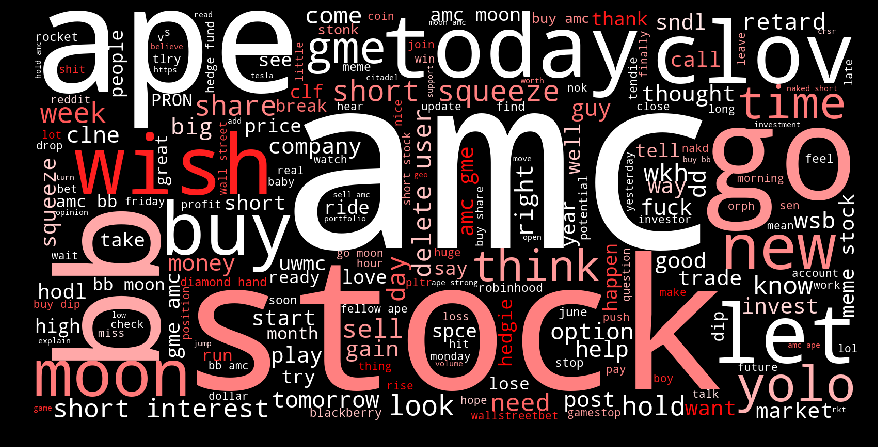

In [14]:
plot_word_cloud(text_tt_after)

## Oct 2020

In [67]:
df_2020 = pd.read_csv('reddit_2020.csv')

In [70]:
df_202010 = df_2020[df_2020['time'] <= '2020-11-01']

In [71]:
%%time
df_202010['tokenized_text'] = df_202010['title'].apply(lambda x: lucem_illud.word_tokenize(x))
df_202010['normalized_tokens'] = df_202010['title'].apply(lambda x: lucem_illud.normalizeTokens(x))

CPU times: user 3.87 s, sys: 1.5 s, total: 5.37 s
Wall time: 8.69 s


In [ ]:
tokens_tt_202010 = df_202010['normalized_tokens'].sum()

In [83]:
countedWords = wordCounter(tokens_tt_202010)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:20]

,word,count
0,$,1500
48,buy,670
199,stock,656
33,call,621
147,go,486
242,option,483
146,market,462
23,trade,442
227,put,380
240,retard,343


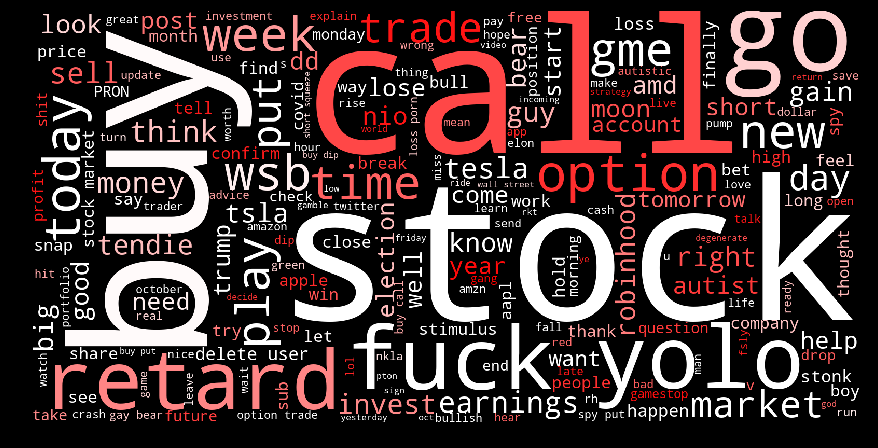

CPU times: user 3.61 s, sys: 479 ms, total: 4.09 s
Wall time: 4.11 s


In [74]:
%%time
text_tt_202010 = ' '.join(tokens_tt_202010)
plot_word_cloud(text_tt_202010)

## all GME posts

In [18]:
%%time
tokens_gme = gme['normalized_tokens'].sum()

CPU times: user 40min 13s, sys: 2min 4s, total: 42min 17s
Wall time: 42min 17s


In [11]:
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(360,100%%, %d%%)" % np.random.randint(50,150))

#@interact(season = "21 spring")
def plot_word_cloud(text):
    #text = ' '.join(data['normalized_tokens'].sum())
    wc = wordcloud.WordCloud(width=1600, height=800,).generate(text)

    wc.recolor(color_func = grey_color_func)
    plt.figure(figsize=(12,12), facecolor='k')
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad=0)
    #plt.savefig('dow_wordcloud.jpg')
    plt.show()

In [19]:
text_gme = ' '.join(tokens_gme)

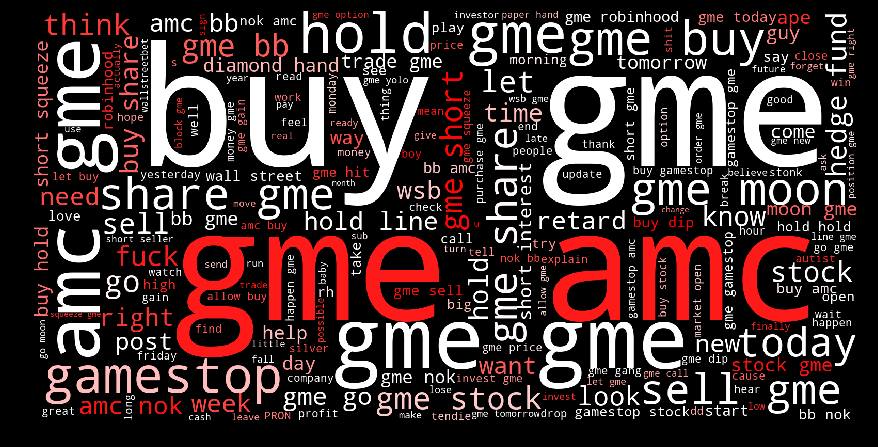

In [20]:
plot_word_cloud(text_gme)

In [82]:
countedWords = wordCounter(tokens_gme)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:20]

,word,count
0,gme,158019
32,🚀,102691
6,$,48938
60,buy,37965
1102,amc,29961
168,hold,20131
79,💎,17848
13,gamestop,16665
375,stock,13398
150,share,12927
